## Includes

In [38]:
import numpy as np
from numpy import sin, matrix, zeros, float32, float64, \
    tanh, linspace, identity, mean, var, Inf, sqrt
from numpy.random import randn
from numpy.linalg import pinv, inv
from conceptor import sprandn, NOT, OR, PHI, ridgeregression, rmsd

## Initialization

In [46]:
Float = float64
randstate = 8
np.random.seed(randstate)
network_size = 200
spectral_radius = 1.5
input_scaling = 1.5
bias_scaling = 1.5
connectivity = 0.1

conceptor_washout_length = 100
learn_length = 500
tychonov_alpha_D = 0.001
tychonov_alpha_out = 0.01
conceptor_aperture = 100
initial_washout = 100
cue_length = 30
cue_noise_level = 0.0

conceptor_adaptation_rate_cue = 0.01
conceptor_adaptation_rate_after_cue = 0.01
sig_to_noise_cue = Inf

measure_washout = 50
measure_template_length = 20
measure_runlength = 500

autoadaptation_runlength = 10000

signal_plot_length = 10
signal_value_plot_length = 20


### Signal generators

In [19]:
scale = 0.5
generators = [
    lambda t: scale*sin(2*np.pi*t/7.34),
    lambda t: scale*sin(2*np.pi*t/8.56),
    lambda t: scale*sin(2*np.pi*t/9.67),
    lambda t: scale*sin(2*np.pi*t/10.78),
    lambda t: scale*sin(2*np.pi*t/11.89),
    lambda t: scale*sin(2*np.pi*t/12.12),
    lambda t: scale*sin(2*np.pi*t/13.23),
    lambda t: scale*sin(2*np.pi*t/14.34)
]
num_patterns = len(generators)

### Setting weights

In [20]:
W_raw = 0.25*sprandn(network_size, network_size, connectivity)
W_in_raw = randn(network_size, 1)
bias_raw = randn(network_size, 1)

W = spectral_radius*W_raw
W_in = input_scaling*W_in_raw
bias = bias_scaling*bias_raw

In [21]:
print W_in.max(), W_in.min()

3.42695848697 -4.02224991229


### Setting up collectors

In [22]:
cue_collector_all = matrix(zeros((network_size, num_patterns*learn_length), Float ))
pattern_template_collector_all = matrix(zeros((1, num_patterns*learn_length), Float))
pattern_templates = matrix(zeros((measure_template_length, num_patterns), Float))

## Looping through inputs

In [23]:
conceptor_all = matrix(zeros((network_size, network_size), Float))
D = zeros((network_size, network_size), Float)
I = identity(network_size)
for pattern_ix in range(num_patterns):
    generator = generators[pattern_ix]
    
    # local collectors
    pattern_template = matrix(zeros((learn_length,1), Float))
    x_cue = matrix(zeros((network_size, learn_length), Float))
    x_prev_collector = matrix(zeros((network_size, learn_length), Float))
    pattern_collector = matrix(zeros((learn_length, 1), Float))
    network_state = zeros((network_size, 1), Float)
    
    for time in range(conceptor_washout_length):
        inp = generator(time)
        network_state = tanh(W*network_state + W_in*inp + bias)
        
    for time in range(learn_length):
        inp = generator(time + conceptor_washout_length)
        x_prev = network_state
        network_state = tanh(W*network_state + W_in*inp + bias)
        x_cue[:, time] = network_state
        x_prev_collector[:, time] = x_prev
        pattern_template[time,0] = inp
    
    pattern_templates[:, pattern_ix] = \
        pattern_template[-measure_template_length::1]
    startix = pattern_ix*learn_length
    stopix = (pattern_ix+1)*learn_length
    cue_collector_all[:, startix:stopix] = x_cue
    pattern_template_collector_all[0, startix:stopix] = pattern_template.transpose()
    
    # compute D increment
    D_target = matrix(W_in*pattern_template.transpose() -\
        D*x_prev_collector)
    F = matrix(NOT(conceptor_all))
    D_args = matrix(F * x_prev_collector)
    D_inc = (pinv(D_args*D_args.transpose() / learn_length + \
                pow(conceptor_aperture,-2)*I) * \
                D_args*D_target.transpose()/learn_length).transpose()
    
    # update D and conceptor_all
    D = D + D_inc
    R = x_prev_collector*x_prev_collector.transpose()/(learn_length+1)
    conceptor_native = R * inv(R + I)
    conceptor_w_aperture = PHI(conceptor_native, conceptor_aperture)
    conceptor_all = OR(conceptor_all, conceptor_w_aperture)
    

## Ridge regression

In [24]:
# compute weights for readout
W_out = ridgeregression(cue_collector_all, 
                        pattern_template_collector_all,
                        tychonov_alpha_out)
RMSE_out = rmsd(W_out*cue_collector_all, pattern_template_collector_all, True)
print RMSE_out

0.000329029880087


## Conceptor test

In [56]:
network_variance = mean(var(cue_collector_all.transpose()))
y_test_plot = zeros((measure_runlength, num_patterns, 2), Float) 

for pattern_ix in range(num_patterns):
    generator = generators[pattern_ix]
    network_state = zeros((network_size,1), Float)
    
    # washout
    for time in range(initial_washout):
        inp = generator(time)
        network_state = tanh(W*network_state + W_in*inp + bias)
    
    conceptor = zeros((network_size, network_size), Float)
    noisy_bias = sqrt(network_variance/sig_to_noise_cue) 
    
    for time in range(cue_length):
        inp = generator(time + initial_washout) + cue_noise_level*randn()
        network_state = tanh(W*network_state + W_in*inp + bias) + \
            noisy_bias*randn(network_size, 1)
        conceptor = conceptor + conceptor_adaptation_rate_cue* \
            ((network_state-conceptor*network_state)*network_state.transpose() -\
             pow(conceptor_aperture, -2)*conceptor)
    
    # measure before adaptation
    netw_before_measure = network_state
    for time in range(measure_washout):
        network_state = conceptor*tanh(W*network_state + D*network_state +\
                                       bias)
    
    for time in range(measure_runlength):
        r = tanh(W*network_state + D*network_state + bias)
        network_state = conceptor*r
        y_test_plot[time, pattern_ix, 0] = W_out*r
    network_state = netw_before_measure
    
    for time in range(autoadaptation_runlength):
        network_state = conceptor * tanh(W*network_state + D*network_state +\
                                         bias) + noisy_bias*randn(network_size,1)
        conceptor = conceptor + conceptor_adaptation_rate_after_cue *\
                    ((network_state - conceptor*network_state)*network_state.transpose() -\
                     pow(conceptor_aperture, -2)*conceptor)
    # measure again
    netw_before_measure = network_state
    for time in range(measure_washout):
        network_state = conceptor*tanh(W*network_state + D*network_state +\
                                       bias)
    
    for time in range(measure_runlength):
        r = tanh(W*network_state + D*network_state + bias)
        network_state = conceptor*r
        y_test_plot[time, pattern_ix, 1] = W_out*r
        # print y_test_plot[time, pattern_ix,
    network_state = netw_before_measure
    

### Plotting 

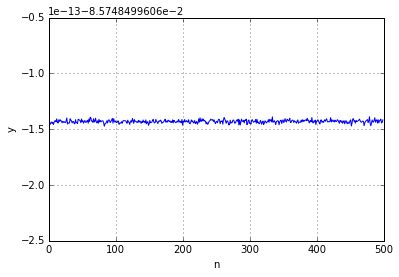

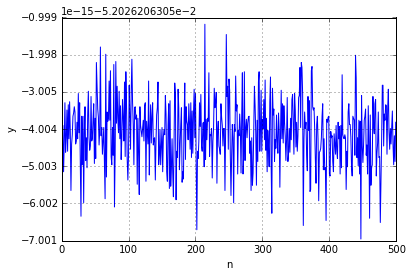

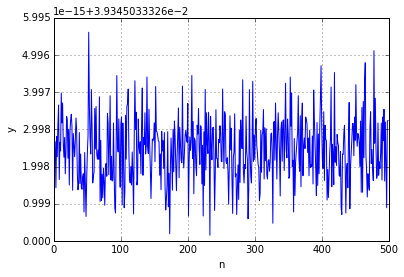

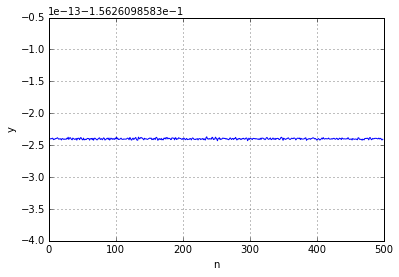

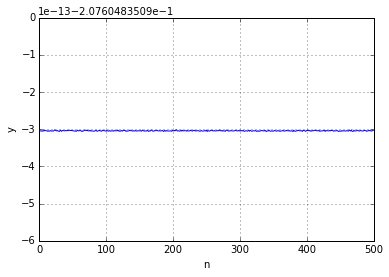

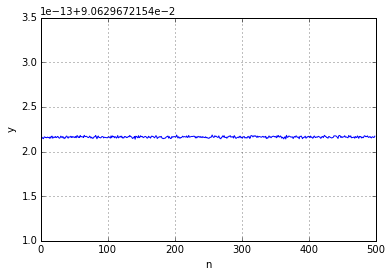

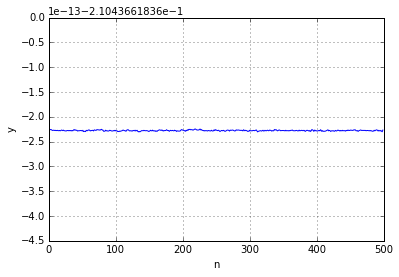

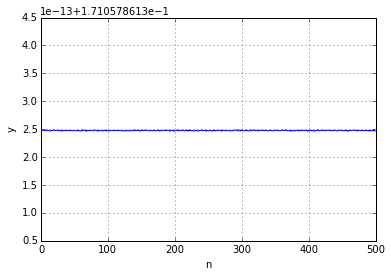

In [52]:
from matplotlib.pyplot import figure, plot, xlabel, ylabel, grid, show
%matplotlib inline

t = linspace(0,measure_runlength-1, measure_runlength)
# plot
for i in range(num_patterns):
    figure()
    plot(t,y_test_plot[:, i, 0],'b')
    xlabel('n'), ylabel('y')
    grid()
    show()

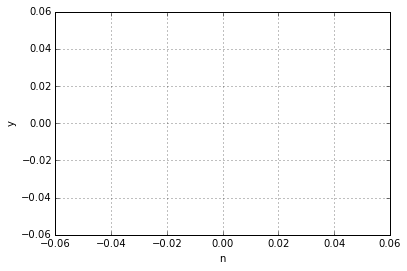

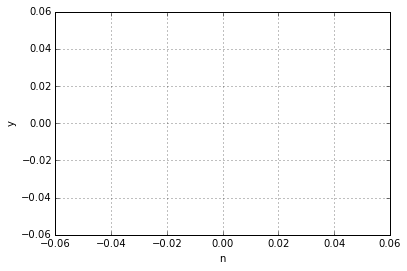

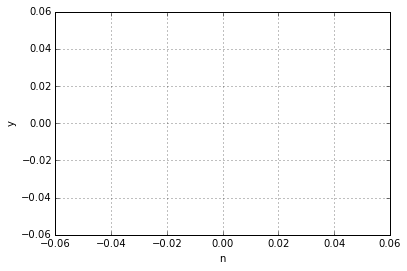

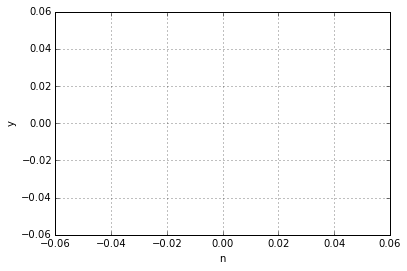

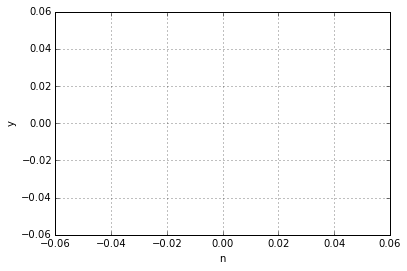

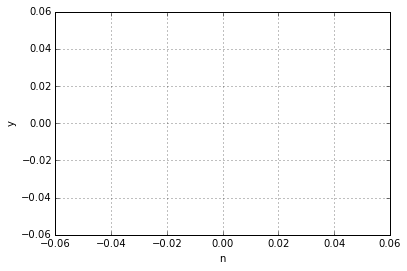

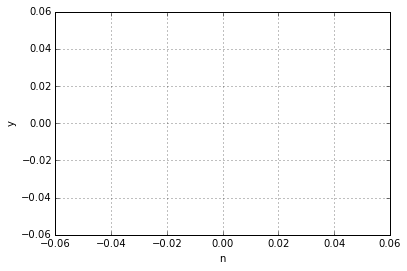

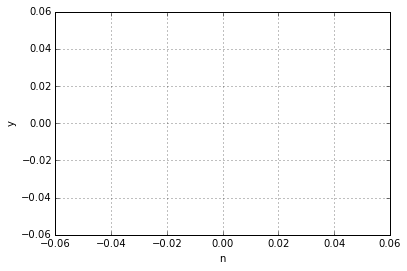

In [53]:
# plot
for i in range(num_patterns):
    figure()
    plot(t,y_test_plot[:, i, 1],'b')
    xlabel('n'), ylabel('y')
    grid()
    show()

In [41]:
randn(3,1)

array([[ 1.09128273],
       [-1.94697031],
       [-1.38634953]])